In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

resources_path = Path('../../Resources/').resolve() # change this to the local path of the course package
sys.path.append(str(resources_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= resources_path / 'introdl')

The `introdl` module is already installed.


In [2]:
# imports and configuration

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchinfo import summary
from sklearn.metrics import mean_absolute_error

from introdl.utils import get_device, load_results, load_model, config_paths_keys
from introdl.idlmam import train_simple_network
from introdl.visul import plot_training_metrics

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']


MODELS_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models
DATA_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data
TORCH_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads


c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\introdl\idlmam\idlmam.py:31: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Nonlinear Regression Example

## Curve Fitting Activity

The folks at Carnegie Mellon University maintain a version of the Neural Network Playground for one-dimensional curve fitting and classification problems. 

You should open this <a href="https://www.cs.cmu.edu/~pvirtue/tfp/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-saw&learningRate=0.03&regularizationRate=0&noise=50&networkShape=4&seed=0.50727&showTestData=false&discretize=false&percTrainData=50&x=true&collectStats=false&problem=regression&initZero=false&hideText=false" target="_blank">pre-configured version</a> and tinker with the app to answer the the following questions about using a neural network to fit the one-dimensional "M" curve. To play with the app, you should focus mostly on changing the structure of the network.  You can train the network by pressing the "play" button.

1. Does a network with a single hidden layer with 4 neurons reliably fit the curve?  Reliably means that it nearly always converges to the correct curve when the network is retrained.  Small networks will often get stuck in local minima that don't fit the data well.
2. Try two hidden layers.  Is it reliable now?  How many neurons do you need?  Does it converge more quickly if the layers are larger?
3. By adding more neurons and layers can you better predict the "M" shape and make training more reliable?
4. Try reducing the "Ratio of training to test data" to 10%.  Now fit a complex network to the data.  What do you notice about the curve?  Is it getting the general pattern or is memorizing the wiggles in the small training set?

<details> 
<summary>AFTER TRYING ON YOUR OWN CLICK HERE TO REVEAL OUR ANSWERS.</summary>

1. This small network will have trouble fitting the curve.  This small network can fit the "M"-curve quite well, but the training will usually get stuck in a way that the network misses one or both peaks.
2. With 6 neurons and 2 neurons, the network will sometimes fit the M well.  With 6 and 6 it seems to nearly always fit the curve well, though it might be a little slow to converge.  With 8 and 8 it seems to always fit well and converge quickly.
3. Increasing the number of hidden layers and neurons even further doesn't seem to help much.  The fit isn't any better and the rate of convergence is the same.
4. We tried 4 hidden layers with eight neurons each.  The network seems to be trying to fit the wiggles in the data instead of the overall "M"-shaped pattern.

</details>

## A Note on Splitting the Data

In the first couple of lessons we're going to use only a **train-test splits** which is fine for quick prototyping or if you're using cross-validation on the training set. If the dataset is small to begin with, then using a **train-validation-test** split  may not be possible because there simply isn't have enough data.  Cross-validation is used in some research papers, but it is rare in real-world deep learning workflows because training models is resource and time intensive.

If you have a large dataset you should nearly always use a **train-validation-test** split.  Most of the time in deep learning we need to adjust hyperparameters, like the learning rate and batch size, and we want to try various model architectures and optimizers. If all of these variations are done to the test set then we risk overfitting on that set with no means to assess the performance of our final deep learning pipeline on unseen data.

With a **train-validation-test** split the setup is:
  - The **training set** is used to train the model.
  - The **validation set** is used to tune hyperparameters, select models, and monitor for overfitting.
  - The **test set** is used to evaluate final model performance and should only be used **once**, after model selection and tuning, to assess generalization to unseen data.

Validation sets are critical for:

- **Hyperparameter optimization**: Avoiding overfitting on the test set.
- **Model comparison**: Selecting the best-performing model based on validation metrics.
- **Early stopping**: Using validation loss to decide when to stop training.

If you use only a test set for hyperparameter tuning and model selection, you risk overfitting to the test data, making the test results less meaningful. Using a validation set ensures the test set remains untouched for final performance evaluation.

We'll introduce train-validation-test splits in Lesson 3.

## Our First Model in PyTorch

Now we'll follow the steps below to implement and train a similar model in PyTorch.  Based on our experiments in the activity above we'll use a fully-connected neural network with two hidden layers each containing eight neurons.

1. Prepare the Data

2. Configure the Model

3. Train the Model

4. Evaluate the Model

5. Make Predictions

Those five steps are common to any machine learning workflow.  Often we'll repeat some of those steps, particularly Step 2-4, multiple times until we're satisfied with the results.

### Step 1 - Prepare the Data

Here is a video walkthrough for Step 1: [L01_2_prepare_the_data](https://share.descript.com/view/6mXJjH6NFJ8).

For this example we'll first create synthetic data then we'll use PyTorch Datasets and DataLoaders to get in the form we'll use for  model training.

#### Create Synthetic Data

We'll generate two sets of 400 points each for training and testing.  You can dig through the code below if you want details about how we're generating the data, but in short:
* Generate a bunch of $x$-values.  We're using a uniform distribution to generate these.
* Each $y$-value is computed by applying a formula $f(x)$ and adding normally distributed random noise.

At the end of this we want our neural network to be a reasonable approximation to $f(x)$.  Note that normally distributed random noise has mean 0 and standard deviation of 0.5.  This means that most of the $y$-values are within $\pm 0.5$ of the underlying true $y$-values.  We'll recall this fact later when we try to assess the quality of our trained model.

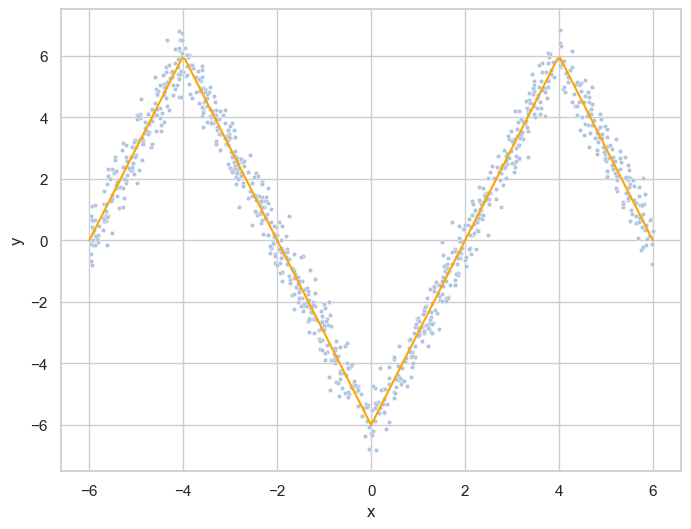

In [2]:
torch.manual_seed(42); # make results reproducible

def MCurve(x):
    """
    The "M" curve function.

    Parameters:
    - x (torch.Tensor): The input values.

    Returns:
    - y (torch.Tensor): The output values.
    """
    return 3 * F.relu(x + 6) - 6 * F.relu(x + 4) + 6 * F.relu(x) - 6 * F.relu(x - 4)  # f(x) is an "M" curve

def makeMCurveData(num_samples, std_dev=0.5):
    """
    Generate synthetic data for the "M" curve.

    Parameters:
    - num_samples (int): The number of data points to generate.
    - std_dev (float): The standard deviation of the noise added to the data.

    Returns:
    - x (torch.Tensor): The input values.
    - y (torch.Tensor): The output values with added noise.
    """
    x = torch.rand(num_samples) * 12 - 6
    y = MCurve(x)
    noise = std_dev * torch.randn(num_samples)  # normally distributed noise
    return x, y + noise

n = 1000
x_train, y_train = makeMCurveData(n) # roughly the same as in NN Playground
x_test, y_test = makeMCurveData(n) 

x_grid = torch.linspace(-6,6,201)
y_true = MCurve(x_grid)

sns.scatterplot(x = x_train, y = y_train, s = 10, legend = False, color='lightsteelblue');
sns.lineplot(x=x_grid, y=y_true, color='orange')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Think of the orange "M-curve" as the ground truth that we are trying to estimate from noisy data.

### Create Pytorch Datasets

First we need to adjust the shapes of our data tensors

In [3]:
print(x_train.shape)
print(y_train.shape)

torch.Size([1000])
torch.Size([1000])


Pytorch models can process multiple inputs simultaneously but we'll need to make our inputs into a nested tensor to do that.

#### Reshape

We want our input tensor to have shape `[batch_size, num_features]` or `[1000,1]` in this case.

Here's an example to show how `reshape` can be used:

In [4]:
x = torch.tensor([1,2,3,4])
print('1D tensor')
print(x)
print(x.shape)

print('\n2D tensor')
x2 = x.reshape(-1,1) # make [N,1] shape where N is the number of elements in x
print(x2)
print(x2.shape)

1D tensor
tensor([1, 2, 3, 4])
torch.Size([4])

2D tensor
tensor([[1],
        [2],
        [3],
        [4]])
torch.Size([4, 1])


#### The training and testing Datasets

In PyTorch, a `Dataset` is an abstract class that serves as a blueprint for accessing and processing data.

`TensorDataset` is a special `Dataset` class that is useful for small datasets that fit easily in memory in Pytorch tensors.

In [5]:
train_dataset = TensorDataset(x_train.reshape(-1,1), 
                              y_train.reshape(-1,1))
test_dataset = TensorDataset(x_test.reshape(-1,1), 
                             y_test.reshape(-1,1))

#### The DataLoaders

In PyTorch, a `DataLoader` wraps a `Dataset` to manage batching, shuffling, and parallel data loading, making data feeding efficient during model training and evaluation.

Shuffling the training data is important because it helps to prevent the model from learning patterns specific to the order of the data, leading to better generalization.

In [6]:
batch_size = 50 # we set this the same as in Neural Network playground
train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size, 
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                         batch_size = batch_size, 
                         shuffle=False)

####  A sample batch
It's a good idea to inspect a batch of the data to see if it's what you expect.  

It's also good to note the shape of a batch because we'll use that to shape to make sure our PyTorch neural network model is behaving as expected.

In [7]:
xb, yb = next(iter(train_loader))
print(xb[:5],'\n')
print(xb.shape,'\n')
print(yb[:5])

tensor([[3.3201],
        [4.6919],
        [2.6617],
        [2.4562],
        [0.1799]]) 

torch.Size([50, 1]) 

tensor([[ 3.6703],
        [ 3.7641],
        [ 1.3313],
        [ 1.3150],
        [-5.4604]])


### Step 2 - Configure the Model

Here is a video walkthrough for Step 2: [L01_2_configure_the_model](https://share.descript.com/view/ylXSAeD5IaA).

* 2 hidden layers with 8 neurons each
* hyperbolic tangent activation functions
* use `torch.nn.Sequential` for simple networks

In [8]:
model = nn.Sequential(
    nn.Linear(1, 8),   # First hidden layer (input: 1, output: 8)
    nn.Tanh(),         # Tanh activation function
    nn.Linear(8, 8),   # Second hidden layer (input: 8, output: 8)
    nn.Tanh(),         # Tanh activation function
    nn.Linear(8, 1)    # Output layer (input: 8, output: 1)
    )

#### Define the model as a class

While the're nothing wrong with using the `Sequential` class to define simple models, it does have a couple of disadvantages.

First, if you need to make a new instance of the model you'll have to copy the code.  Second, more complex models will require us to define the models directly as classes that inherit from the `nn.Module` class.  We'll start doing that right away so you get used to it.

If you're completely unfamiliar with Object-Oriented Programming in Python I recommend this [Real Python Tutorial](https://realpython.com/python3-object-oriented-programming/).  Written and video versions are available.

In [9]:
class CurveFitter(nn.Module):
    # The __init__ method in a PyTorch model, often called the constructor, 
    # is used to initialize the model's layers and any other parameters or 
    # components needed for the model. This method is called when an instance 
    # of the model is created.  All the layers that involve model parameters 
    # must be declared here.  The activation functions can be put here 
    # or in the forward method as we'll see later.
    #
    # The super() function is used to call the constructor of the parent class.
    def __init__(self):
        super(CurveFitter, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 8),   # First hidden layer (input: 1, output: 8)
            nn.Tanh(),         # Tanh activation function
            nn.Linear(8, 8),   # Second hidden layer (input: 8, output: 8)
            nn.Tanh(),         # Tanh activation function
            nn.Linear(8, 1)    # Output layer (input: 8, output: 1)
        )

    # The forward method defines the forward pass of the model.  
    # It's called every time we execute the model on input data.
    def forward(self, x):
        return self.model(x)

model = CurveFitter()
model

CurveFitter(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

#### Summarizing a model

When you're building PyTorch models or even applying existing models to new data, the number one source of errors is mismatched tensor shapes.  `torchinfo.summary` is great for seeing how the batch of input data changes shape as it moves through the network.  If there is an issue with mismatched sizes, you'll get an error message that shows you the last layer that was able to be executed which is super helpful in diagnosing shape errors.

In [10]:
summary(model, input_size = (40,1), col_width=16,
        col_names = ["input_size","output_size","num_params"])

Layer (type:depth-idx)                   Input Shape      Output Shape     Param #
CurveFitter                              [40, 1]          [40, 1]          --
├─Sequential: 1-1                        [40, 1]          [40, 1]          --
│    └─Linear: 2-1                       [40, 1]          [40, 8]          16
│    └─Tanh: 2-2                         [40, 8]          [40, 8]          --
│    └─Linear: 2-3                       [40, 8]          [40, 8]          72
│    └─Tanh: 2-4                         [40, 8]          [40, 8]          --
│    └─Linear: 2-5                       [40, 8]          [40, 1]          9
Total params: 97
Trainable params: 97
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

### Step 3 - Train the model

Here is a video walkthrough for Step 3: [L01_2_train_the_model](https://share.descript.com/view/P5XcxjuNC2u).

To setup training:

* choose loss function
* choose metric(s) if desired
* set device to cpu or gpu if available
* determine a name for saved model file

In [11]:
# Mean Square Error Loss
loss_func = nn.MSELoss()

# Mean Absolute Error metric for monitoring
score_funcs = {'MAE':mean_absolute_error}

# determine device to run the model on
device = get_device() # from course package
print(f"Using device: {device}")

# checkpoint filename for saving model
ckpt_file = MODELS_PATH / 'L01_MCurveData_CurveFitter.pt'

Using device: cuda


Notes:

* It isn't required to choose a separate metric that is different from the loss function, but we often want to do so.  In this case Mean absolute error gives a better sense of the average vertical deviation of the fitted curve and a data point while the mean squared error loss can be harder to interpret.

* Note, I'm either training on a gaming PC with an Nvidia GPU or a Macbook Pro, so you'll see that my device is either 'cuda' or 'mps'.  In CoCalc and other platforms you'll either use a 'cpu' or 'cuda' if a GPU is available.   We use the get_device function from the course Python package to see what device is available.


#### Setting the device

Just so you can see how it works, here is the code for the 'get_device' function.  We put it in the package so it would be easy to change later if other hardware gets PyTorch support.

In [12]:
def get_device():
    """
    Returns the appropriate device ('cuda', 'mps', or 'cpu') depending on availability.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

### Do the training

Initially, we'll make use of `train_simple_network` from the textbook.  Use the version from the course package (imported at the top of the notebook) since we've added a couple of tweaks.  Here's the function signature so you can read about the inputs:

In [13]:
?train_simple_network

Signature:
train_simple_network(
    model,
    loss_func,
    train_loader,
    test_loader=None,
    score_funcs=None,
    epochs=50,
    device='cpu',
    checkpoint_file=None,
    lr=0.001,
    use_tqdm=True,
)
Docstring:
Trains a simple neural network model using the specified loss function and data loaders.

Args:
    model (torch.nn.Module): The neural network model to train.
    loss_func (torch.nn.Module): The loss function to optimize during training.
    train_loader (torch.utils.data.DataLoader): The data loader for the training dataset.
    test_loader (torch.utils.data.DataLoader, optional): The data loader for the testing dataset. Defaults to None.
    score_funcs (list, optional): List of evaluation score functions to track during training. Defaults to None.
    epochs (int, optional): The number of training epochs. Defaults to 50.
    device (str, optional): The device to use for training (e.g., "cpu" or "cuda"). Defaults to "cpu".
    checkpoint_file (str, optional): 


In our experiments with Neural Network playground we saw that a learning rate of 0.03 worked well and that the training converged in 200-300 epochs.  We'll run for 600 epochs here just to be sure we're converged.  We're also using a larger batch size (50) than in the playground to expedite training.  

Note - the training sometimes yields a model that isn't a great fit to the data because the optimization gets stuck in a poor-quality local minimum.  You can rerun the code to see if does better or you can load a model from our checkpoint file.  Later in the course we'll see how to use better optimizers that are less likely to get stuck.

In [14]:
model = CurveFitter() # instantiate a newly initialized model

results_df = train_simple_network(model, 
                                  loss_func, 
                                  train_loader, 
                                  device=device, 
                                  epochs = 600, 
                                  lr = 0.03, 
                                  checkpoint_file=ckpt_file, 
                                  test_loader=test_loader,
                                  score_funcs = score_funcs,
                                  use_tqdm=True)

Epoch:   0%|          | 0/600 [00:00<?, ?it/s]

### Step 4 - Evaluate the Model

Here is a video walkthrough for Step 4: [L01_2_evaluate_the_model](https://share.descript.com/view/e6HmrPxo2oR).

To evaluate the model we are usually interested in a couple of things.
1. How well does the model perform on data that the model wasn't trained on?  
2. Is the model underfitting or overfitting?  

In the world of deep learning rarely is underfitting an issue, but overfitting will be common so we'll keep an eye out for it.

Since we're training the model once as a quick prototype we'll just use the test dataset from our train-test split.  By inspecting loss and other metrics on both the train and test set we can assess both the model performance and whether it is overfitting.

#### Inspect convergence loss and metrics

We could simply refer to `results_df` here to see the loss and metrics, but we'll show how to load it from the checkpoint file.  That's really useful so you don't have to retrain the model just to review the results.  A little later we'll introduce a `load_results` function to simplify loading results from a checkpoint file.

In [15]:
ckpt_file = MODELS_PATH / 'L01_MCurveData_CurveFitter.pt' # load parameters from checkpoint
checkpoint_dict = torch.load(ckpt_file, weights_only=False, map_location=torch.device('cpu')) 
results_df = pd.DataFrame(checkpoint_dict['results']) # convert results to DataFrame

results_df

,epoch,total time,train loss,test loss,train MAE,test MAE
0,0,0.145294,10.075071,11.398497,2.696844,2.832345
1,1,0.168802,8.776958,8.898204,2.477073,2.491768
2,2,0.201506,5.315486,4.205360,1.902550,1.730464
3,3,0.226633,2.506785,2.075022,1.250840,1.131597
4,4,0.251169,1.907846,1.886008,1.061727,1.068246
...,...,...,...,...,...,...
595,595,42.879240,0.895907,0.944090,0.665131,0.670176
596,596,42.956309,0.894483,0.964544,0.661275,0.677930
597,597,43.038883,0.910658,0.965471,0.670650,0.690252
598,598,43.122529,0.888025,0.945309,0.654585,0.677879


It's hard to tell from the mean squared error if our model is doing a good job of fitting the data, but look at the mean absolute error.  It converges to a value around 0.5 for both the testing and training data.  This means that, on average, the predicted $y$_values are within $\pm 0.5$ of target $y$-values.  Recall that the standard deviation of noise in the target $y$-values was 0.5.  Since the errors in predicting the target values are similar to the magnitude of the noise in the original target values, we can't really do any better than that!

You can also see that both MSE and MAE are converging pretty similarly for both the test and training sets.  This is exactly what we'd like to see.  This means the model is neither underfitting or overfitting.

(Truth in advertising - this particular model and training combination often gets stuck in a local minimum that doesn't fit the data as well as it could similar to what happens in Neural Network Playground.  These issues could be addressed by introducing a more complex model and improving the training.  We'll see more about improved training in Lesson 3.  This version of the model still serves as good introduction to a deep learning workflow in PyTorch.)

### Inspect convergence graphically

It's often more helpful to see the training metrics visually instead of looking at the raw values.

In the next cell we show you how to plot the metrics using `seaborn.`

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,3) )

sns.set_palette('colorblind')

sns.lineplot(x='epoch',y='train loss',data=results_df,label='Train', ax=axes[0]);
sns.lineplot(x='epoch',y='test loss',data=results_df,label='Test', ax=axes[0]);
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE Loss vs Epoch');

sns.lineplot(x='epoch',y='train MAE',data=results_df,label='Train', ax=axes[1]);
sns.lineplot(x='epoch',y='test MAE',data=results_df,label='Test', ax=axes[1]);
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE vs Epoch');


Or you could use `plot_training_metrics` (an interactive version is also available `plot_training_metrics_widget`).  The `results_df` is probably still in memory, but we'll also show you how to `load_results` to get it here.  These functions are available in the course `introdl` package.

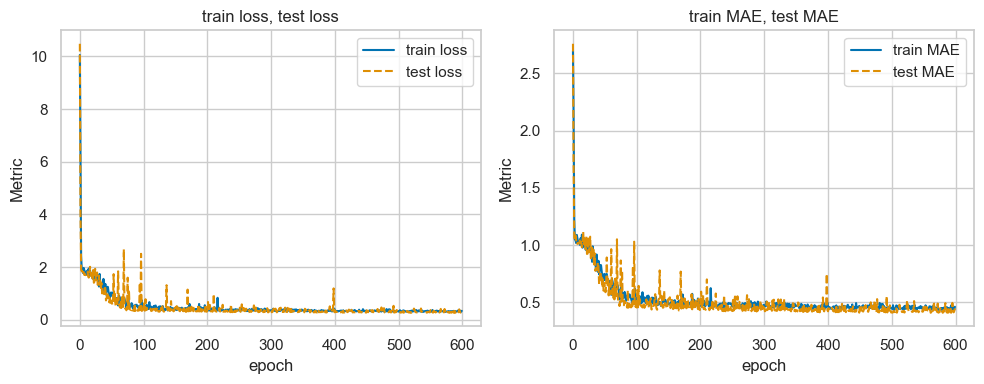

In [3]:
results_df = load_results(MODELS_PATH / 'L01_MCurveData_CurveFitter.pt') # load results from checkpoint and returns data frame

plot_training_metrics(results_df,[['train loss', 'test loss'],['train MAE', 'test MAE']])

#### Visualize the fit

We can already see from the mean absolute error on the test data that our trained model is doing a good job, but for this curve-fitting problem it's relatively easy to visualize how well the trained network fits the data.  First we'll create a new instance of the model and overwrite its randomly initialized parameter values with the saved parameters from our checkpoint file.

In [ ]:
model = CurveFitter() # new instance of model

ckpt_file = MODELS_PATH / 'L01_MCurveData_CurveFitter.pt' # load parameters from checkpoint
checkpoint_dict = torch.load(ckpt_file, weights_only=False, map_location=torch.device('cpu')) 
model.load_state_dict(checkpoint_dict['model_state_dict']); 

Loading models from checkpoint files is something we'll do often so to streamline this process we've provided a `load_model` function in the `introdl` package.  

In [ ]:
# you can either pass in the model instance or the class
model = load_model(CurveFitter, MODELS_PATH / 'L01_MCurveData_CurveFitter.pt')

# this would also work
# model = CurveFitter() # create a new instance of the model
# model = load_model(model, MODELS_PATH / 'L01_MCurveData_CurveFitter.pt')

Now we evaluate the model on a sequence of equally spaced inputs for visualization.  We'll discuss the code below in the next section, when we discuss using a model to make predictions for new data, but here's the plot.

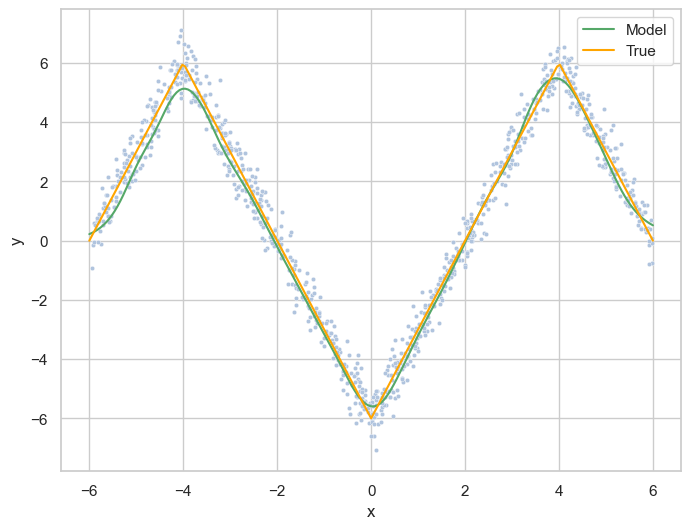

In [20]:
x = torch.linspace(-6,6,201).reshape(-1,1) # add a batch dimension
model.to(torch.device('cpu')) # move model to CPU if necessary
with torch.no_grad():
    y = model(x)
y_true = MCurve(x)

# Add the scatter plot for noisy y-values
sns.scatterplot(x=x_test, y=y_test, s=10, color = "lightsteelblue") # blue
sns.lineplot(x=x.squeeze(),y=y.squeeze(),color="#55A868",label="Model") # green
sns.lineplot(x=x.squeeze(),y=y_true.squeeze(),color="orange",label="True") # orange

plt.xlabel('x')
plt.ylabel('y');


The model does a great job (at least this time) of fitting the data approximates well the underlying groundtruth "M-curve".

### Step 5 - Make Predictions

Here is a video walkthrough for Step 5: [L01_2_make_predictions](https://share.descript.com/view/P25g0EleiQH).

We just did this in the last code cell, but let's look at how we did it.  To use a trained model to make predictions using new inputs requires a bit of preparation.  There are a few things to do:

1.  Prepare the new input data for the model.  This usually means converting to a tensor with the appropriate shape.
2.  Load the model and put in evaluation mode so that PyTorch knows to not compute gradients.
3.  Make the sure the model and data are on the same device.
4.  If necessary, convert the raw model outputs into the predictions you want and convert those predictions into the data type or structure you need.

Let's tackle this writing a function to do most of these steps.  You may need to build a similar function for your application or problem.  First decide what formats you want for the input and output data.  In this example we'll use PyTorch tensors, but you might want Numpy arrays, lists, or something else.

#### Make Predictions from PyTorch Tensors

Here we're assuming that that $x$-values (the features) where you want to evaluate the model are in a PyTorch tensor with shape $[N,1]$.  Where $N$ is the number of $x$-values and the 1 is because each feature is a single number.  The data and model are likely to be on the 'cpu' already, but it doesn't hurt to make sure.  You may want to use a GPU if one is available for large models.

In [21]:
def predict1d(model, x, device=torch.device('cpu')):
    """
    Predict the output of a model for input value(s).

    Parameters:
    - model (nn.Module): The PyTorch model.
    - x (torch.Tensor): The input value(s). Must have a shape of (N,1).
    - device (torch.device): The device to run the model on.

    Returns:
    - y (torch.Tensor): The model's output. Will have shape (N,1).
    """
    model.to(device) # move model to device
    model.eval() # set model to evaluation mode
    x = x.to(device) # move input to device

    with torch.no_grad():
        y = model(x.float()) # make predictions for input value(s)
    return y

Now we'll make predictions for a few arbitrary points:

In [22]:
x = torch.tensor([1,2,3,4]).reshape(-1,1)
y = predict1d(model,x)
y

tensor([[-3.1988],
        [-0.0669],
        [ 2.9659],
        [ 5.4682]])

#### Making Predictions from Numpy Arrays

A more typical use case might be to make predictions for values in a Numpy array.  We'll make a new function that converts the numpy array to a PyTorch tensor, applies the model, then converts the output back to a Numpy array.

In [23]:
import numpy as np

def predict1d_numpy(model, x, device=torch.device('cpu')):
    """
    Predict the output of a model for input value(s).

    Parameters:
    - model (nn.Module): The PyTorch model.
    - x (numpy.ndarray): The input value(s). Must have a shape of (N,).
    - device (torch.device): The device to run the model on.

    Returns:
    - y (numpy.ndarray): The model's output. Will have shape (N,).
    """
    x_tensor = torch.from_numpy(x).reshape(-1, 1)
    y_tensor = predict1d(model, x_tensor, device)
    y = np.squeeze(y_tensor.cpu().numpy()) # move to CPU and convert to numpy, squeeze removes dimensions of size 1
    return y


Now we can use our function to make predictions and plot the results.

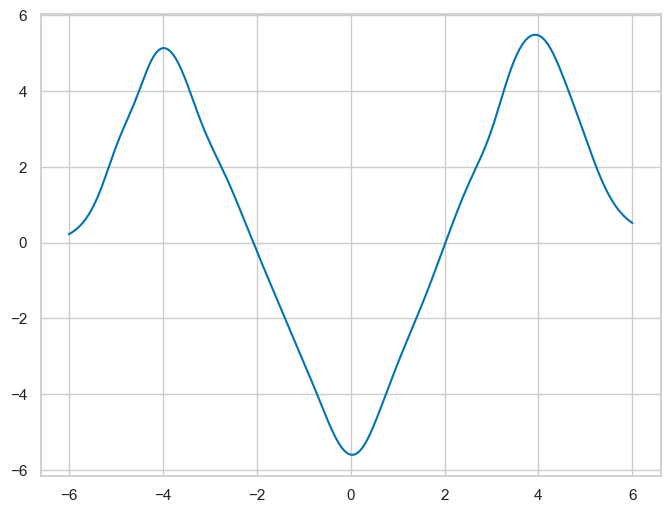

In [24]:
x = np.linspace(-6,6,201)
y = predict1d_numpy(model,x)
plt.plot(x,y,label='Model')